In [1]:
import copy
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calculate_daily_return(row):
    return row['Close'] - row['Open']

In [3]:
def expected_value(values):
    return statistics.mean(values)

In [4]:
def confidence_interval(data, confidence=0.95):
    dist = statistics.NormalDist.from_samples(data)
    z = statistics.NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h

In [5]:
def load_stock(filename):
    data = pd.read_csv('../yahoo/{}'.format(filename))
    data['Gross Return'] = data.apply(calculate_daily_return, axis=1)
    data['Pct Return'] = data.apply(lambda row: 100*row['Gross Return']/row['Open'], axis=1)
    return data

In [29]:
def create_dataframes(stockList, compName, datatype='daily'):
    if datatype == 'monthly':
        ext = '{}_10y_bymonth.csv'
    else:
        ext = '{}_10y.csv'
    comp = load_stock(ext.format(compName))
    comp_var = get_composite_var(comp)

    stocks = pd.DataFrame({'B_im': [0 for n in range(len(stockList))],
                           'cov': [0 for n in range(len(stockList))]}, index=stockList)
    for stock in stockList:
        stock_data = load_stock(ext.format(stock))
        c = calc_cov(comp, stock_data, 'Pct Return')
        stocks.loc[stock, 'cov'] = c
        stocks.loc[stock, 'B_im'] = calc_B_im(stock_data, comp, 'Pct Return', comp_var=comp_var, cov=c)
    periodical_data = pd.DataFrame({'Comp Return' : comp['Pct Return']})
    for stock in stockList:
        stock_data = load_stock(ext.format(stock))
        periodical_data['{} Return'.format(stock)] = stock_data['Pct Return']
    return stocks, periodical_data, comp

In [30]:
def calc_E_rm(series, mult_columns=True):
    if mult_columns:
        t = np.trapz(series['Pct Return'])/len(series.index)
    else:
        t = np.trapz(series)/len(series.index)
    return t

In [31]:
def get_composite_var(composite):
    return composite.var()

def calc_cov(comp, stock, metric):
#     cov_data = pd.DataFrame()
    dates = list(stock['Date'])
    cov_data = pd.DataFrame({'Date': dates,
                            'Comp Met': [comp.iloc[i][metric] for i in range(len(comp.index)) if comp.iloc[i]['Date'] in dates],
                            'Stock Met': [stock.iloc[i][metric] for i in range(len(stock.index))]})
#     cov_data['Comp Metric'] = cov_data.apply(lambda row: comp[comp['Date'] == row[1][0]][metric])
#     cov_data['Stock Metric'] = cov_data.apply(lambda row: stock[stock['Date'] == row[1][0]][metric])
#     for row in stock.iterrows():
#         comp_row = comp.loc[comp['Date']==row['Date']]
#         print(comp_row)
#         comp_met = comp[metric]
#         stock_met = row[metric]
#         cov_data.append([row['Date'], comp_met, stock_met])
#     cov_data.columns = ['Date', 'Comp Met', 'Stock Met']
#     print(cov_data.head())
    return cov_data['Stock Met'].cov(cov_data['Comp Met'])

def calc_B_im(stock, comp, metric, comp_var=None, cov=None):
    if comp_var[metric] == None:
        comp_var = get_composite_var(comp)
    if cov == None:
        cov = calc_cov(comp, stock, metric)
    return cov/comp_var[metric]

In [32]:
def get_a_im(R_om, stocks, stocklist):
    expected_R_om = calc_E_rm(R_om, mult_columns=False)
    a_ims = []
    for stockName in stockList:
        parentheses = float(1.0 - stocks['B_im'][stockName])
        a_ims.append(expected_R_om * parentheses)
    stocks['a_im'] = a_ims
    return stocks

In [33]:
def weighted_portfolio(stocks, weights=[]):
    if len(weights) != len(stocks):
        weights = [1/len(stocks.index) for i in range(len(stocks.index))]
    print(weights)
    portfolio = copy.copy(stocks)
    combo = pd.Series([stocks['B_im'].dot(weights), 0, stocks['a_im'].dot(weights)], index=portfolio.columns, name="Weighted")
    portfolio = portfolio.append(combo)
    return portfolio

In [55]:
def create_regression(stocks, comp, periodic_data):
    regression = pd.DataFrame({'Date': copy.copy(comp['Date']),
                           'R_m': copy.copy(comp['Pct Return'])})
    for stock in stocks.index:
        regression['R_i {}'.format(stock)] = regression.apply(lambda row: stocks.loc[stock, 'B_im']*row['R_m'] + stocks.loc[stock, 'a_im'], axis=1)
        regression['True {}'.format(stock)] = copy.copy(periodic_data['{} Return'.format(stock)])
    
    return regression

In [56]:
def find_R_om(period_data):
    R_om = pd.Series([min(list(row)) for index, row in period_data.iterrows()])
    return R_om

In [57]:
stockList = ['COST', 'INTC', 'AAPL', 'TSLA'] # must download data first
compName = 'NASDAQ'

In [58]:
stocks_d, daily_data, comp_d = create_dataframes(stockList, compName)
stocks_m, monthly_data, comp_m = create_dataframes(stockList, compName, datatype='monthly')

In [59]:
monthly_data.head()

,Comp Return,COST Return,INTC Return,AAPL Return,TSLA Return
0,6.325943,-3.311765,2.978942,5.182598,5.558241
1,-0.376471,7.232359,3.980344,2.954805,61.030082
2,4.775414,5.864243,-2.003719,2.312302,-25.759688
3,2.702703,-1.250865,2.141832,4.200954,-10.208644
4,2.922504,3.558571,-0.093071,3.489606,-1.727684


In [61]:
R_om_daily = find_R_om(daily_data)
stocks_d = get_a_im(R_om_daily, stocks_d, stockList)
portfolio_d = weighted_portfolio(stocks_d)
regression_d = create_regression(stocks_d, comp_d, daily_data)

[0.25, 0.25, 0.25, 0.25]


In [62]:
R_om_monthly = find_R_om(monthly_data)
stocks_m = get_a_im(R_om_monthly, stocks_m, stockList)
portfolio_m = weighted_portfolio(stocks_m)
regression_m = create_regression(stocks_m, comp_m, monthly_data)

[0.25, 0.25, 0.25, 0.25]


In [68]:
def plot_reg(stocks, regression, hasWeighted=True, n_pts=10, title='CAPM Regression compared to NASDAQ composite'):
    plt.figure(figsize=(15, 10))
    axes = plt.gca()
    axes.set_xlabel('R_m: market return')
    axes.set_ylabel('R_i for all i: regressed return per stock')
    r2_list = []
    for stock in stocks.index[:-1]:
        plt.plot(regression['R_m'], regression['R_i {}'.format(stock)], label='{} reg'.format(stock))
        plt.scatter(list(regression['R_m'])[::n_pts], list(regression['True {}'.format(stock)])[::n_pts], label='{} values'.format(stock))
        
        correlation_matrix = np.corrcoef(regression['R_i {}'.format(stock)], regression['True {}'.format(stock)])
        correlation_xy = correlation_matrix[0,1]
        r_squared = correlation_xy**2
        r2_list.append(r_squared)
    # Weighted
    if hasWeighted:
        r_m_pts = np.linspace(regression['R_m'].min(),regression['R_m'].max(),100)
        weighted_line = stocks.iloc[len(stocks.index)-1]['B_im']*r_m_pts + stocks.iloc[len(stocks.index)-1]['a_im']
        plt.plot(r_m_pts, weighted_line, 'k', label='equal weighted line')
    plt.legend()
    plt.title(title)
    plt.show()
    return r2_list

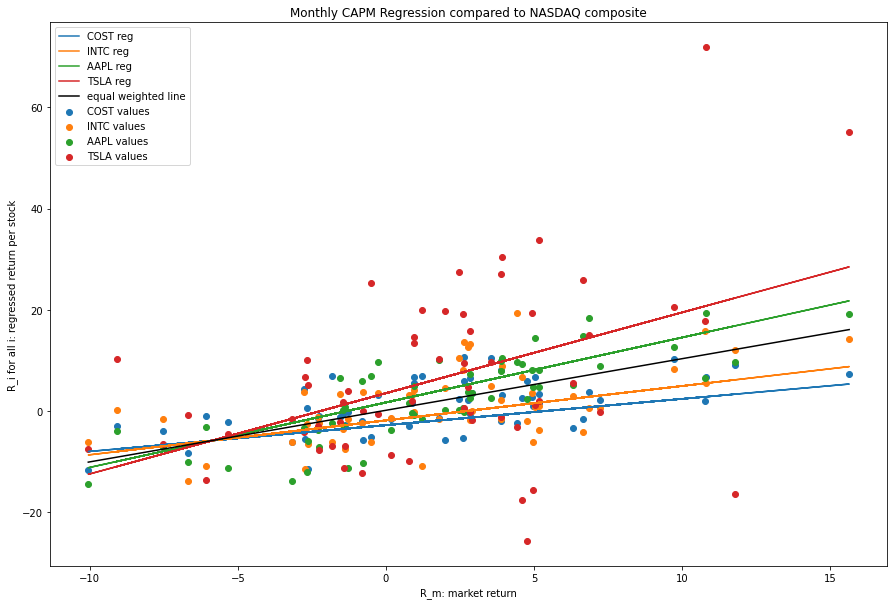

In [80]:
r2m = plot_reg(portfolio_m, regression_m, n_pts=2, title='Monthly CAPM Regression compared to NASDAQ composite')

In [81]:
r2m

[0.2623934468551822,
 0.21852880302265626,
 0.548380689551829,
 0.16499786120177307]

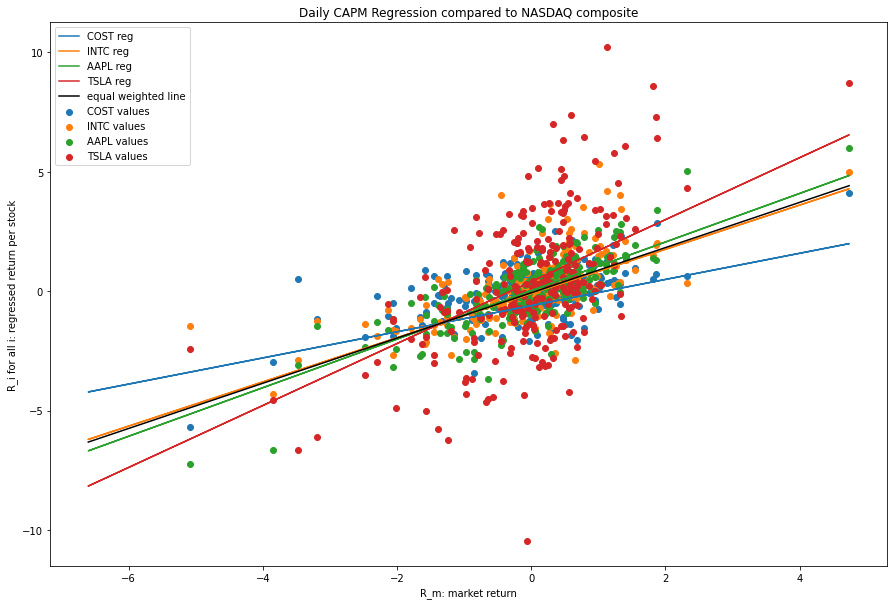

In [71]:
r2 = plot_reg(portfolio_d, regression_d, title='Daily CAPM Regression compared to NASDAQ composite')

In [73]:
nasdaq = load_stock('NASDAQ_10y.csv')
zero_int = confidence_interval(list(nasdaq['Pct Return']))
zero_int

(-0.003156899863176209, 0.06795753314186687)

In [75]:
stocks_d['a_im']

COST   -0.607848
INTC   -0.100781
AAPL    0.021704
TSLA    0.397761
Name: a_im, dtype: float64

In [77]:
stocks_d['Zero intercept (95% conf)'] = stocks_d.apply(lambda row: (row['a_im']>zero_int[0] and row['a_im']<zero_int[1]), axis=1)
stocks_d.to_csv('testing.csv')

In [78]:
daily_data.to_csv('daily_data.csv')

In [79]:
nasdaq.to_csv('nasdaq.csv')